In [1]:
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.python.platform import gfile
from random import randint
import os
from scipy.misc import imsave
from matplotlib import pyplot as plt

In [2]:
def unpickle(file):
  fo = open(file, 'rb')
  dict = pickle.load(fo, encoding='latin1')
  fo.close()
  return dict

def initWeight(shape):
    weights = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(weights)

# start with 0.1 so reLu isnt always 0
def initBias(shape):
    bias = tf.constant(0.1,shape=shape)
    return tf.Variable(bias)

# the convolution with padding of 1 on each side, and moves by 1.
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME")

# max pooling basically shrinks it by 2x, taking the highest value on each feature.
def maxPool2d(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

def conv_seq(input_thing, layer_in, layer_out, filter_size):
    wConv = initWeight([filter_size, filter_size,layer_in, layer_out])
    bConv = initBias([layer_out])
    conv = conv2d(input_thing, wConv)
    bias = conv + bConv
    relu = tf.nn.relu(bias)
    pool = maxPool2d(relu)

    return wConv, bConv, relu, pool

In [3]:
batchsize = 50;
imagesize = 32;
colors = 3;
keepProb = tf.placeholder("float");

In [4]:
sess = tf.InteractiveSession()

img = tf.placeholder("float",shape=[None,imagesize,imagesize,colors])
lbl = tf.placeholder("float",shape=[None,10])

In [5]:
wConv1, bConv1, relu1, pool1 = conv_seq(img, colors, 32, 5)
wConv2, bConv2, relu2, pool2 = conv_seq(pool1, 32, 64, 5)
wConv3, bConv3, relu3, pool3 = conv_seq(pool2, 64, 256,5)
wConv4, bConv4, relu4, pool4 = conv_seq(pool3, 256, 384,5)

In [6]:
'''
with tf.name_scope('layer1'):
    W1 = initWeight([5,5,3,96])    
    b1 = initBias([96])
    conv1 = conv2d(img, W1)        # 96 x 32 x 32
    conv1_bias = conv1 + b1     
    relu1 = tf.nn.relu(conv1_bias)
    pool1 = maxPool2d(relu1)       # 96 x 16 x 16

with tf.name_scope('layer2'):
    W2 = initWeight([3,3,96,256])  
    b2 = initBias([256])
    conv2 = conv2d(pool1, W2)
    conv2_bias = conv2 + b2        # 256 x 16 x 16 
    relu2 = tf.nn.relu(conv2_bias)
    pool2 = maxPool2d(relu2)       # 256 x 8 x 8

with tf.name_scope('layer3'):
    W3 = initWeight([3,3,256,384])  
    b3 = initBias([384])
    conv3 = conv2d(pool2, W3)   # 384 x 8 x 8
    conv3_bias = conv3 + b3
    relu3 = tf.nn.relu(conv3_bias)
    
with tf.name_scope('layer4'):
    W4 = initWeight([3,3,384,256])  
    b4 = initBias([256])
    conv4 = conv2d(relu3, W4)    # 256 x 8 x 8
    conv4_bias = conv4 + b4
    relu4 = tf.nn.relu(conv4_bias)

with tf.name_scope('layer5'):
    pool5 = maxPool2d(relu4)         # 256 x 4 x 4
'''

"\nwith tf.name_scope('layer1'):\n    W1 = initWeight([5,5,3,96])    \n    b1 = initBias([96])\n    conv1 = conv2d(img, W1)        # 96 x 32 x 32\n    conv1_bias = conv1 + b1     \n    relu1 = tf.nn.relu(conv1_bias)\n    pool1 = maxPool2d(relu1)       # 96 x 16 x 16\n\nwith tf.name_scope('layer2'):\n    W2 = initWeight([3,3,96,256])  \n    b2 = initBias([256])\n    conv2 = conv2d(pool1, W2)\n    conv2_bias = conv2 + b2        # 256 x 16 x 16 \n    relu2 = tf.nn.relu(conv2_bias)\n    pool2 = maxPool2d(relu2)       # 256 x 8 x 8\n\nwith tf.name_scope('layer3'):\n    W3 = initWeight([3,3,256,384])  \n    b3 = initBias([384])\n    conv3 = conv2d(pool2, W3)   # 384 x 8 x 8\n    conv3_bias = conv3 + b3\n    relu3 = tf.nn.relu(conv3_bias)\n    \nwith tf.name_scope('layer4'):\n    W4 = initWeight([3,3,384,256])  \n    b4 = initBias([256])\n    conv4 = conv2d(relu3, W4)    # 256 x 8 x 8\n    conv4_bias = conv4 + b4\n    relu4 = tf.nn.relu(conv4_bias)\n\nwith tf.name_scope('layer5'):\n    pool5 

In [7]:
# fully-connected is just a regular neural net: 8*8*64 for each training data
wFc1 = initWeight([int(imagesize/4) * int(imagesize/4) * 64, 1024])
bFc1 = initBias([1024])
# reduce dimensions to flatten
pool2flat = tf.reshape(pool4, [-1, int(imagesize/4) * int(imagesize/4) *64])
# 128 training set by 2304 data points
fc1 = tf.matmul(pool2flat,wFc1) + bFc1;
relu6 = tf.nn.relu(fc1);
# dropout removes duplicate weights
drop = tf.nn.dropout(relu6,keepProb);
wFc2 = initWeight([1024,10]);
bFc2 = initWeight([10]);

In [8]:
# softmax converts individual probabilities to percentages
guesses = tf.nn.softmax(tf.matmul(drop, wFc2) + bFc2);
# how wrong it is
cross_entropy = -tf.reduce_sum(lbl*tf.log(guesses + 1e-9));
# theres a lot of tensorflow optimizers such as gradient descent
# adam is one of them
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy);
# array of bools, checking if each guess was correct
correct_prediction = tf.equal(tf.argmax(guesses,1), tf.argmax(lbl,1));
# represent the correctness as a float [1,1,0,1] -> 0.75
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"));

In [9]:
sess.run(tf.global_variables_initializer());

batch = unpickle("cifar-10-batches-py/data_batch_1")

In [10]:
print(batch["data"].shape)

(10000, 3072)


In [11]:
validationData = batch["data"][555:batchsize+555]
validationRawLabel = batch["labels"][555:batchsize+555]
validationLabel = np.zeros((batchsize,10))
validationLabel[np.arange(batchsize),validationRawLabel] = 1
validationData = validationData/255.0
validationData = np.reshape(validationData,[-1,3,32,32])
validationData = np.swapaxes(validationData,1,3)

In [12]:
saver = tf.train.Saver()

In [13]:
for i in range(20000):
    randomint = randint(0,10000 - batchsize - 1)
    trainingData = batch["data"][randomint:batchsize+randomint]
    rawlabel = batch["labels"][randomint:batchsize+randomint]
    trainingLabel = np.zeros((batchsize,10))
    trainingLabel[np.arange(batchsize),rawlabel] = 1
    trainingData = trainingData/255.0
    trainingData = np.reshape(trainingData,[-1,3,32,32])
    trainingData = np.swapaxes(trainingData,1,3)

    if i%500 == 0:
        train_accuracy = accuracy.eval(feed_dict={
        img: validationData, lbl: validationLabel, keepProb: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

        if i%50 == 0:
            saver.save(sess, os.getcwd()+"/training/train", global_step=i)

    optimizer.run(feed_dict={img: trainingData, lbl: trainingLabel, keepProb: 0.5})

InvalidArgumentError: Input to reshape is a tensor with 76800 values, but the requested shape requires a multiple of 4096
	 [[Node: Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](MaxPool_3, Reshape/shape)]]

Caused by op 'Reshape', defined at:
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-6200727fd0a3>", line 5, in <module>
    pool2flat = tf.reshape(pool4, [-1, int(imagesize/4) * int(imagesize/4) *64])
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6113, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 76800 values, but the requested shape requires a multiple of 4096
	 [[Node: Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](MaxPool_3, Reshape/shape)]]


In [14]:
def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf
    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, out], i)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

In [15]:
print ("displaying")

batchsizeFeatures = 50
imageIndex = 56

inputImage = batch["data"][imageIndex:imageIndex+batchsizeFeatures]
inputImage = inputImage/255.0
inputImage = np.reshape(inputImage,[-1,3,32,32])
inputImage = np.swapaxes(inputImage,1,3)

inputLabel = np.zeros((batchsize,10))
inputLabel[np.arange(1),batch["labels"][imageIndex:imageIndex+batchsizeFeatures]] = 1;

displaying


In [16]:
# saves pixel-representations of features from Conv layer 1
featuresReLu1 = tf.placeholder("float",[None,32,32,32])
unReLu = tf.nn.relu(featuresReLu1)
unBias = unReLu
unConv = tf.nn.conv2d_transpose(unBias, wConv1, output_shape=[batchsizeFeatures,imagesize,imagesize,colors] , strides=[1,1,1,1], padding="SAME")
activations1 = relu1.eval(feed_dict={img: inputImage, lbl: inputLabel, keepProb: 1.0})
print (np.shape(activations1))

(50, 32, 32, 32)


In [17]:
best_list = []
for i in range(32):
    isolated = activations1.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0
    # print ("shape of isolated one:", np.shape(isolated))
    totals = np.sum(isolated,axis=(1,2,3))
    best = np.argmin(totals,axis=0)
    best_list.append(best)
    # print ("best:", best)
    pixelactive = unConv.eval(feed_dict={featuresReLu1: isolated})

/home/joseph/anaconda3/envs/jojo/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


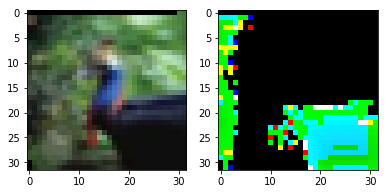

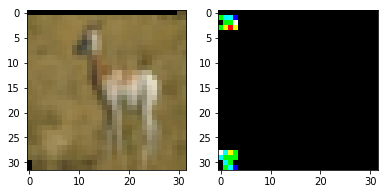

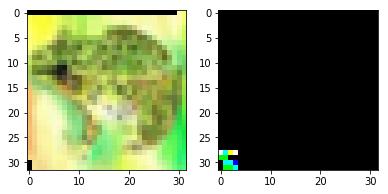

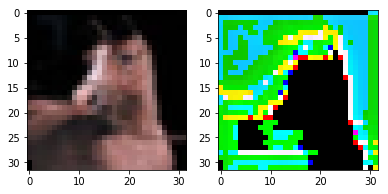

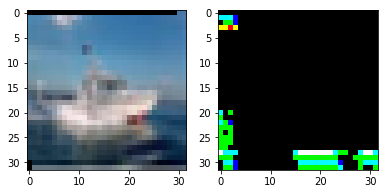

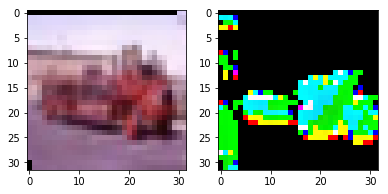

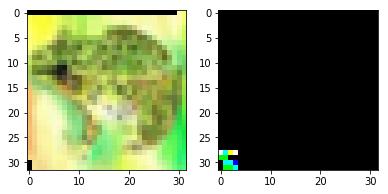

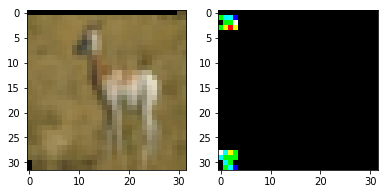

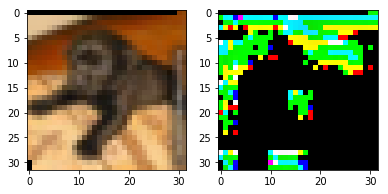

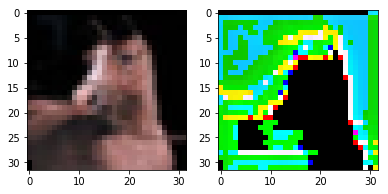

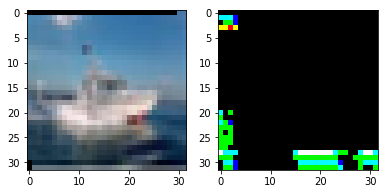

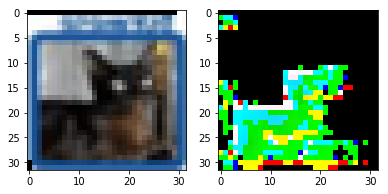

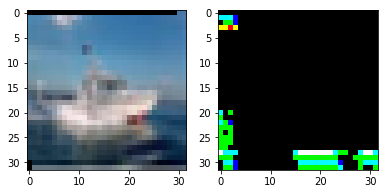

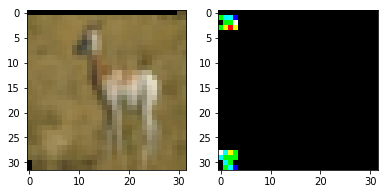

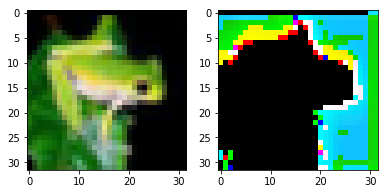

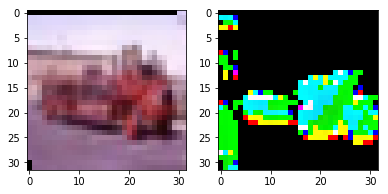

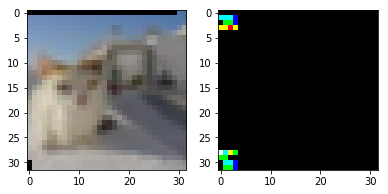

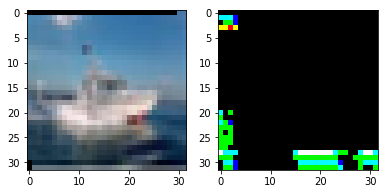

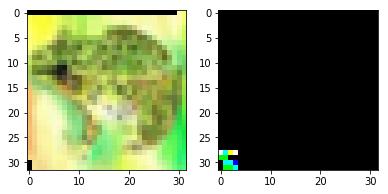

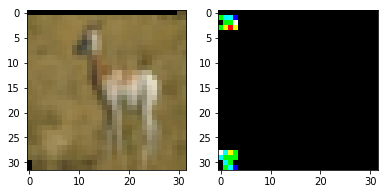

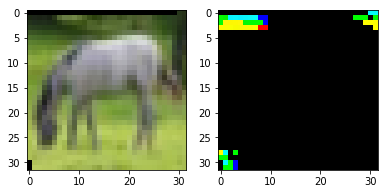

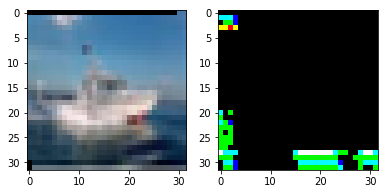

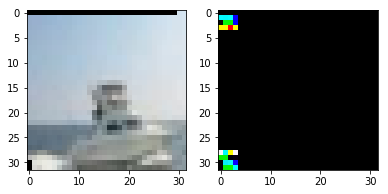

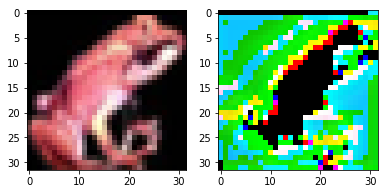

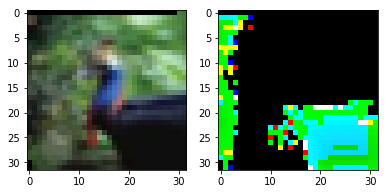

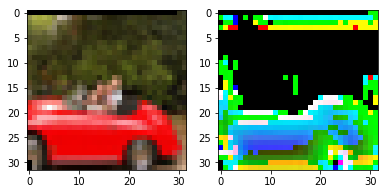

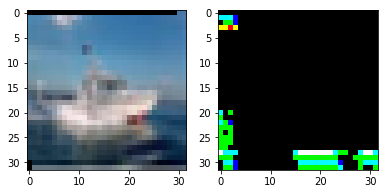

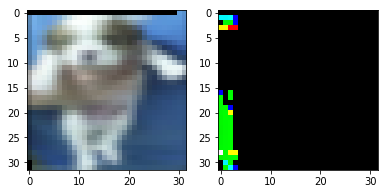

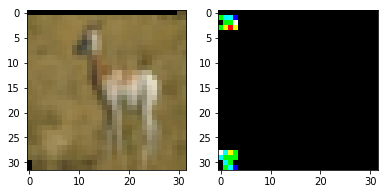

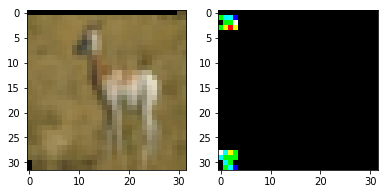

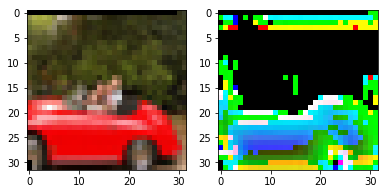

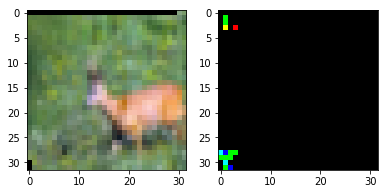

In [18]:
from scipy import ndimage
for best_thing in best_list:
    images = [inputImage[best_thing], pixelactive[best_thing]]
    plt.figure(figsize=(20,10))
    columns = 6
    for i, image in enumerate(images):
        image = ndimage.rotate(image, -90)
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow((image * 255).astype(np.uint8))

In [19]:
# unconv from conv layer 2
featuresRelu2 = tf.placeholder("float", [None,16,16,64])
unRelu2 = tf.nn.relu(featuresRelu2)
unBias2 = unRelu2
unConv2 = tf.nn.conv2d_transpose(unBias2, 
                                 wConv2, 
                                 output_shape = [batchsizeFeatures, int(imagesize/2), int(imagesize/2),32],
                                 strides = [1,1,1,1],
                                 padding="SAME")
unPool = unpool(unConv2)
unRelu = tf.nn.relu(unPool)
unBias = unRelu
unConv = tf.nn.conv2d_transpose(unBias, 
                                wConv1, 
                                output_shape=[batchsizeFeatures,imagesize,imagesize,colors], 
                                strides=[1,1,1,1], 
                                padding="SAME")
activations1 = relu2.eval(feed_dict={img: inputImage, lbl: inputLabel, keepProb: 1.0})
print ("shape of activations1:", np.shape(activations1))

shape of activations1: (50, 16, 16, 64)


In [20]:
best_list = []
for i in range(64):
    isolated = activations1.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0
    pixelactive = unConv.eval(feed_dict={featuresRelu2: isolated})
    totals = np.sum(pixelactive,axis=(1,2,3))
    best = np.argmax(totals,axis=0)
    # best = 0
    best_list.append(best)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

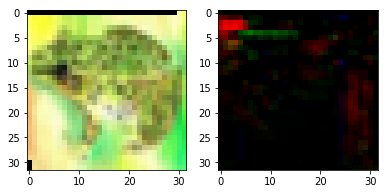

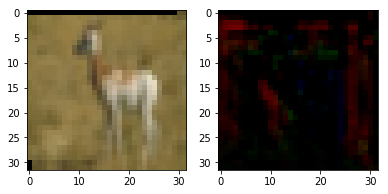

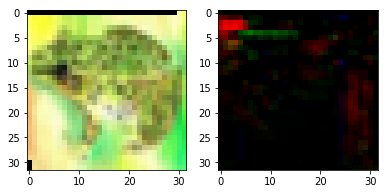

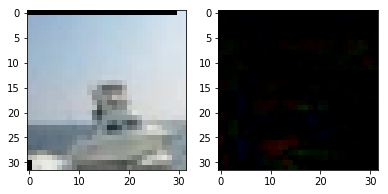

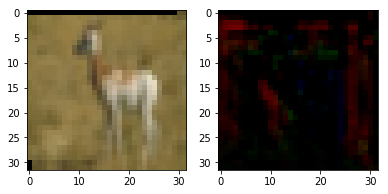

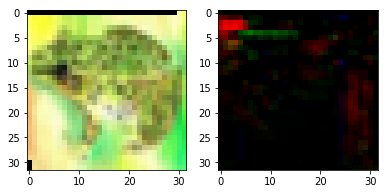

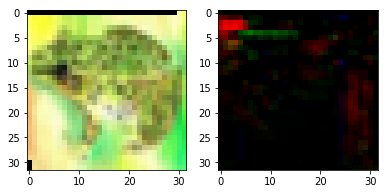

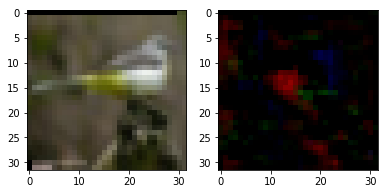

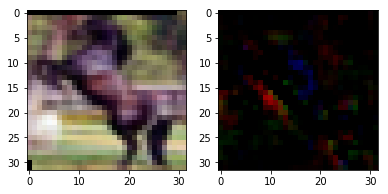

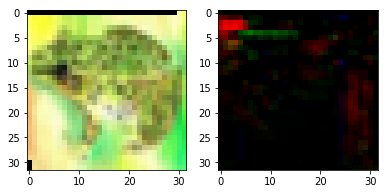

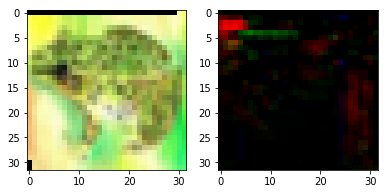

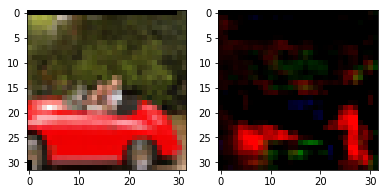

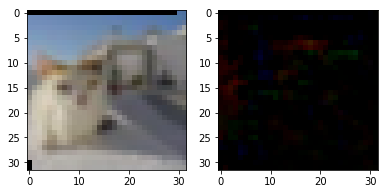

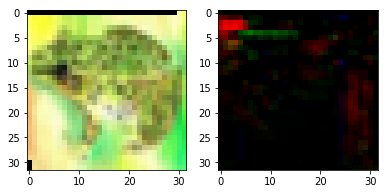

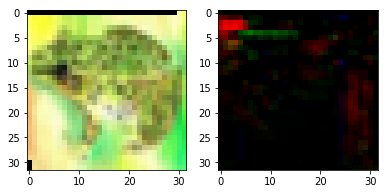

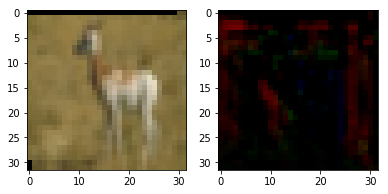

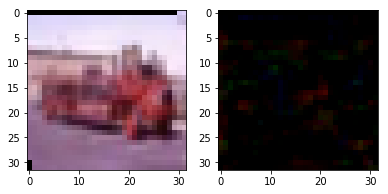

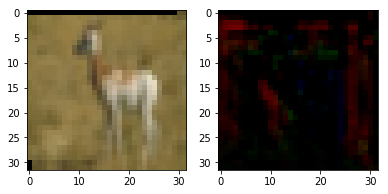

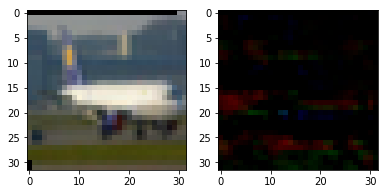

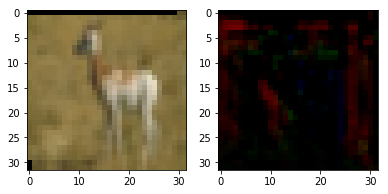

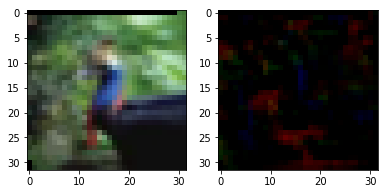

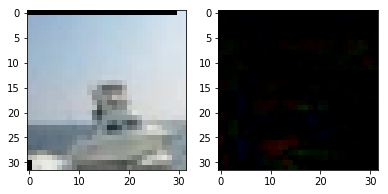

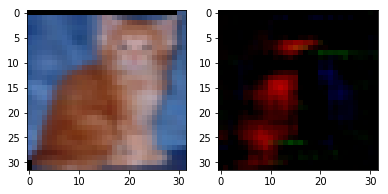

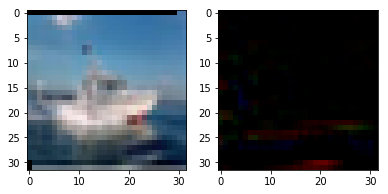

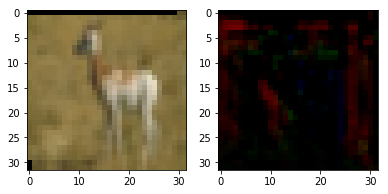

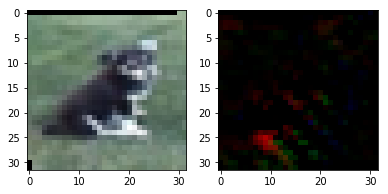

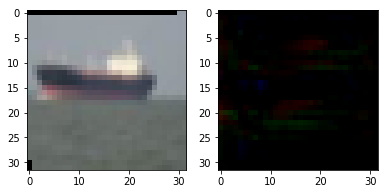

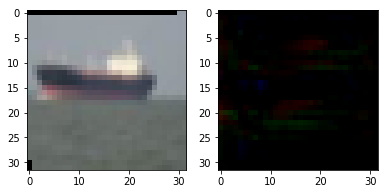

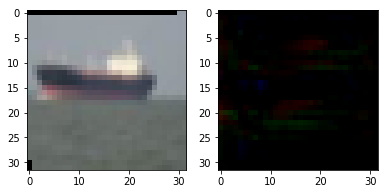

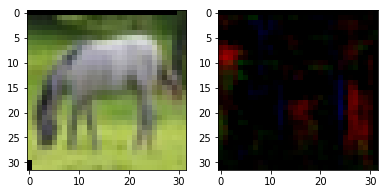

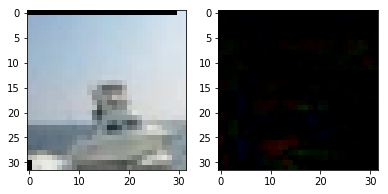

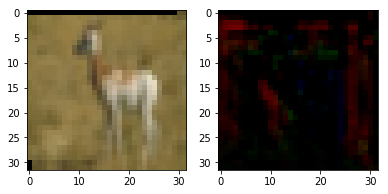

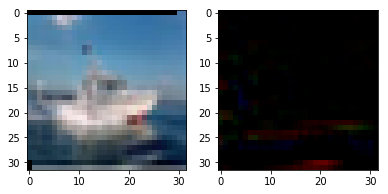

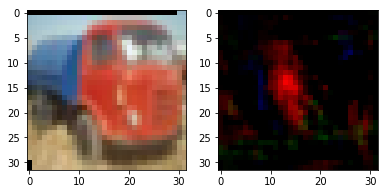

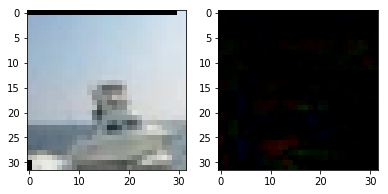

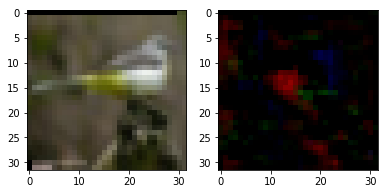

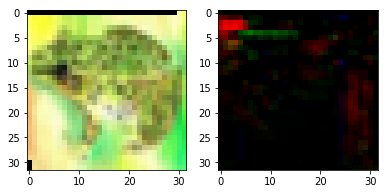

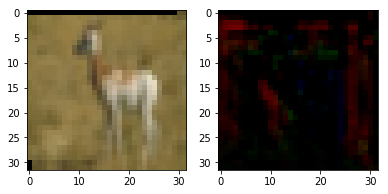

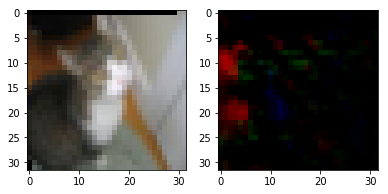

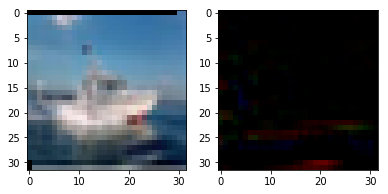

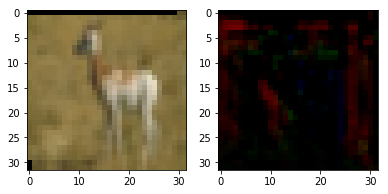

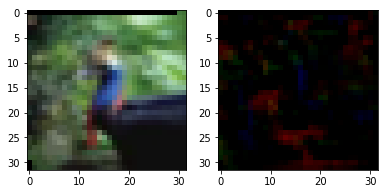

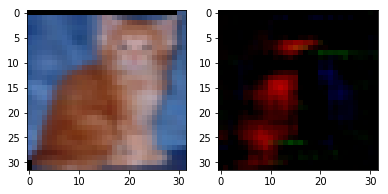

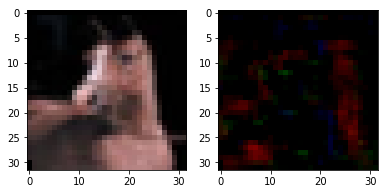

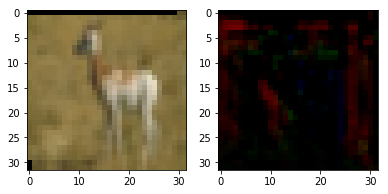

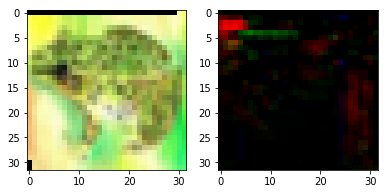

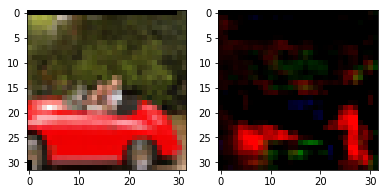

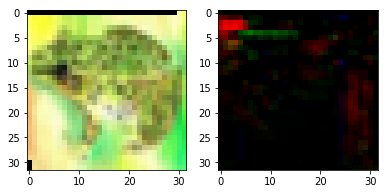

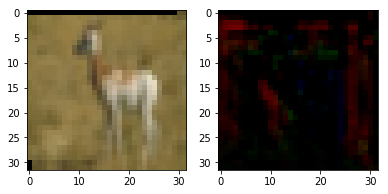

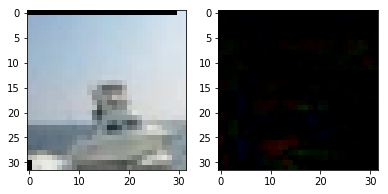

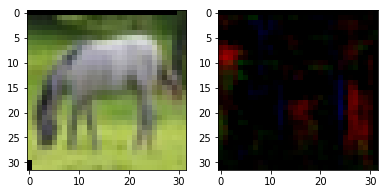

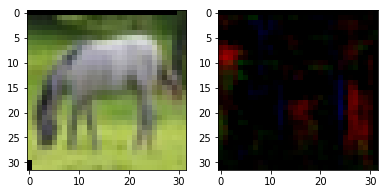

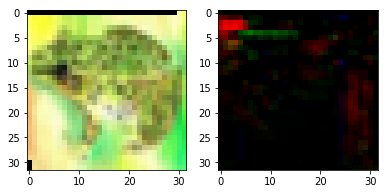

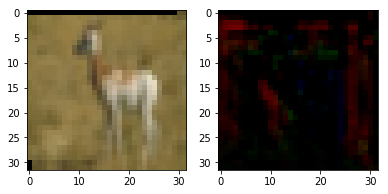

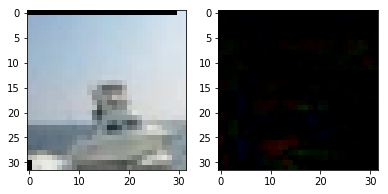

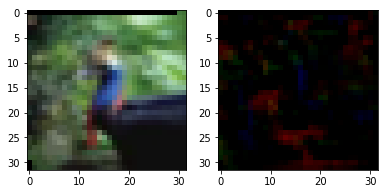

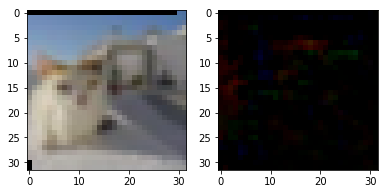

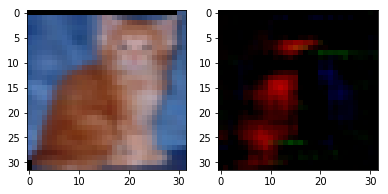

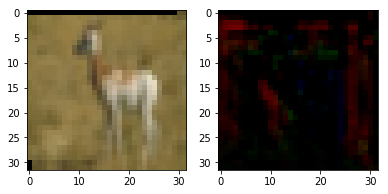

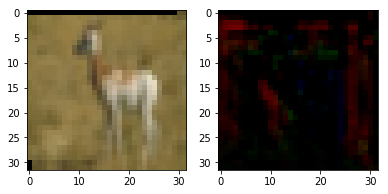

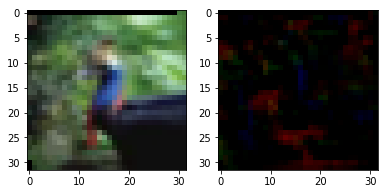

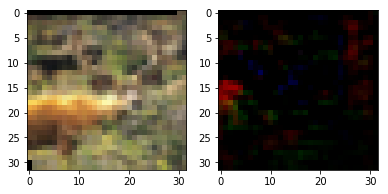

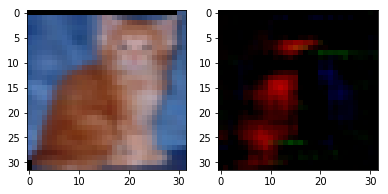

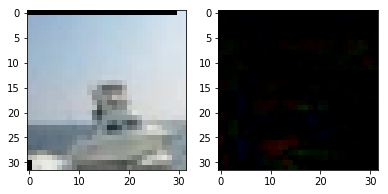

In [21]:
for best_thing in best_list:
    images = [inputImage[best_thing], pixelactive[best_thing]]
    plt.figure(figsize=(20,10))
    columns = 6
    for i, image in enumerate(images):
        image = ndimage.rotate(image, -90)
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)